# Import Libraries and packages

In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (8, 5) },
    style='ticks',
    color_codes=True,
    font_scale=1
)
%config InlineBackend.figure_format = 'retina'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

!pip install category_encoders -q

# ML utilities
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn import metrics

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Encoding and metrics
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Loading the dataset

In [8]:
ecom_data = pd.read_csv('/Users/lapt/Downloads/Dataset_ecommerce.csv')

# Initial inspection of the dataset

In [10]:
ecom_data.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


In [14]:
ecom_data.sample()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
375142,569416,2011-10-04 10:15:00,13801.0,SC2572,Books,7,4.85,Benin


In [16]:
ecom_data.shape

(541909, 8)

In [18]:
ecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   InvoiceDate  541909 non-null  object 
 2   CustomerID   406829 non-null  float64
 3   StockCode    541909 non-null  object 
 4   Description  541909 non-null  object 
 5   Quantity     541909 non-null  int64  
 6   UnitPrice    541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Observation: Sampled Dataset contains 541909 rows and 8 columns in which most of them are strings.

In [21]:
ecom_data.describe()

,CustomerID,Quantity,UnitPrice
count,406829.000000,541909.000000,541909.000000
mean,15287.690570,50.534748,50.476354
std,1713.600303,28.849367,28.564775
min,12346.000000,1.000000,1.000000
25%,13953.000000,26.000000,25.750000
50%,15152.000000,51.000000,50.430000
75%,16791.000000,76.000000,75.180000
max,18287.000000,100.000000,100.000000


In [23]:
# Checking Unique values in the columns
print("Unique Customers:", ecom_data['CustomerID'].nunique())
print("Unique Products:", ecom_data['StockCode'].nunique())
print("Countries:", ecom_data['Country'].nunique())

Unique Customers: 4372
Unique Products: 9000
Countries: 28


In [25]:
ecom_data.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

### Observation - The CustomerID column have 135080 null values (missing data).

# Splitting the features to qualitative and quantitative features

In [29]:
# Categorising quantitative features (numerical columns)
numerical_features = ecom_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Categorising qualitative features (categorical columns)
categorical_features = ecom_data.select_dtypes(include=['object', 'bool']).columns.tolist()

In [31]:
numerical_features

['CustomerID', 'Quantity', 'UnitPrice']

In [33]:
categorical_features

['InvoiceNo', 'InvoiceDate', 'StockCode', 'Description', 'Country']

# Data Cleaning & Preprocessing

## Handling missing values, duplicate values, formatting the InvoiceDate and dropping irrelevant columns

In [37]:
# the percentage of missing values in each columns
missing_pct = round(ecom_data.isna().sum()/len(ecom_data) * 100, 1)
print(missing_pct)

InvoiceNo       0.0
InvoiceDate     0.0
CustomerID     24.9
StockCode       0.0
Description     0.0
Quantity        0.0
UnitPrice       0.0
Country         0.0
dtype: float64


### Observation - ~25% of the CustomerID values are missing which is a significant portion of the dataset. However, since the goal of the project is churn prediction, it is better to drop rows with missing CustomerID in order to have a clean base of identifiable customers for all the cohort and ML modeling tasks.

In [40]:
# Drop rows with missing CustomerID
ecom_data = ecom_data.dropna(subset=['CustomerID'])

In [42]:
# Confirm if the missing CustometID are dropped
print(f"Remaining rows: {ecom_data.shape[0]}")
print(f"Missing CustomerID after drop: {ecom_data['CustomerID'].isna().sum()}")

Remaining rows: 406829
Missing CustomerID after drop: 0


In [44]:
# Check number of duplicates before dropping
duplicate_count = ecom_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [46]:
# Drop irrelevant columns such as InvoiceNo and StockCode
ecom_data = ecom_data.drop(columns=['InvoiceNo', 'StockCode'])

In [48]:
# Convert the date format from string to datetime
ecom_data['InvoiceDate'] = pd.to_datetime(ecom_data['InvoiceDate'])

In [50]:
ecom_data['InvoiceDate'].dtype

dtype('<M8[ns]')

In [52]:
ecom_data['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [54]:
# check the range of dates
print(ecom_data['InvoiceDate'].min(), "to", ecom_data['InvoiceDate'].max())

2010-12-01 08:26:00 to 2011-12-09 12:50:00


# Feature engineering based on domain knowledge

In [57]:
# Create TotalPrice feature
ecom_data['TotalPrice'] = ecom_data['Quantity'] * ecom_data['UnitPrice']

In [59]:
# Extract features such as InvoiceMonth, Invoice year and Weekday
ecom_data['InvoiceMonth'] = ecom_data['InvoiceDate'].dt.to_period('M')
ecom_data['Weekday'] = ecom_data['InvoiceDate'].dt.day_name()

In [61]:
ecom_data['InvoiceYear'] = ecom_data['InvoiceDate'].dt.year

In [63]:
ecom_data['CohortMonth'] = ecom_data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [65]:
ecom_data.head()

,InvoiceDate,CustomerID,Description,Quantity,UnitPrice,Country,TotalPrice,InvoiceMonth,Weekday,InvoiceYear,CohortMonth
0,2010-12-01 08:26:00,17850.0,Electronics,65,10.23,Egypt,664.95,2010-12,Wednesday,2010,2010-12
1,2010-12-01 08:26:00,17850.0,Furniture,95,19.61,Mali,1862.95,2010-12,Wednesday,2010,2010-12
2,2010-12-01 08:26:00,17850.0,Books,78,61.49,Mali,4796.22,2010-12,Wednesday,2010,2010-12
3,2010-12-01 08:26:00,17850.0,Toys,15,24.73,South Africa,370.95,2010-12,Wednesday,2010,2010-12
4,2010-12-01 08:26:00,17850.0,Toys,50,38.83,Rwanda,1941.50,2010-12,Wednesday,2010,2010-12


# Exploratory Data Analysis

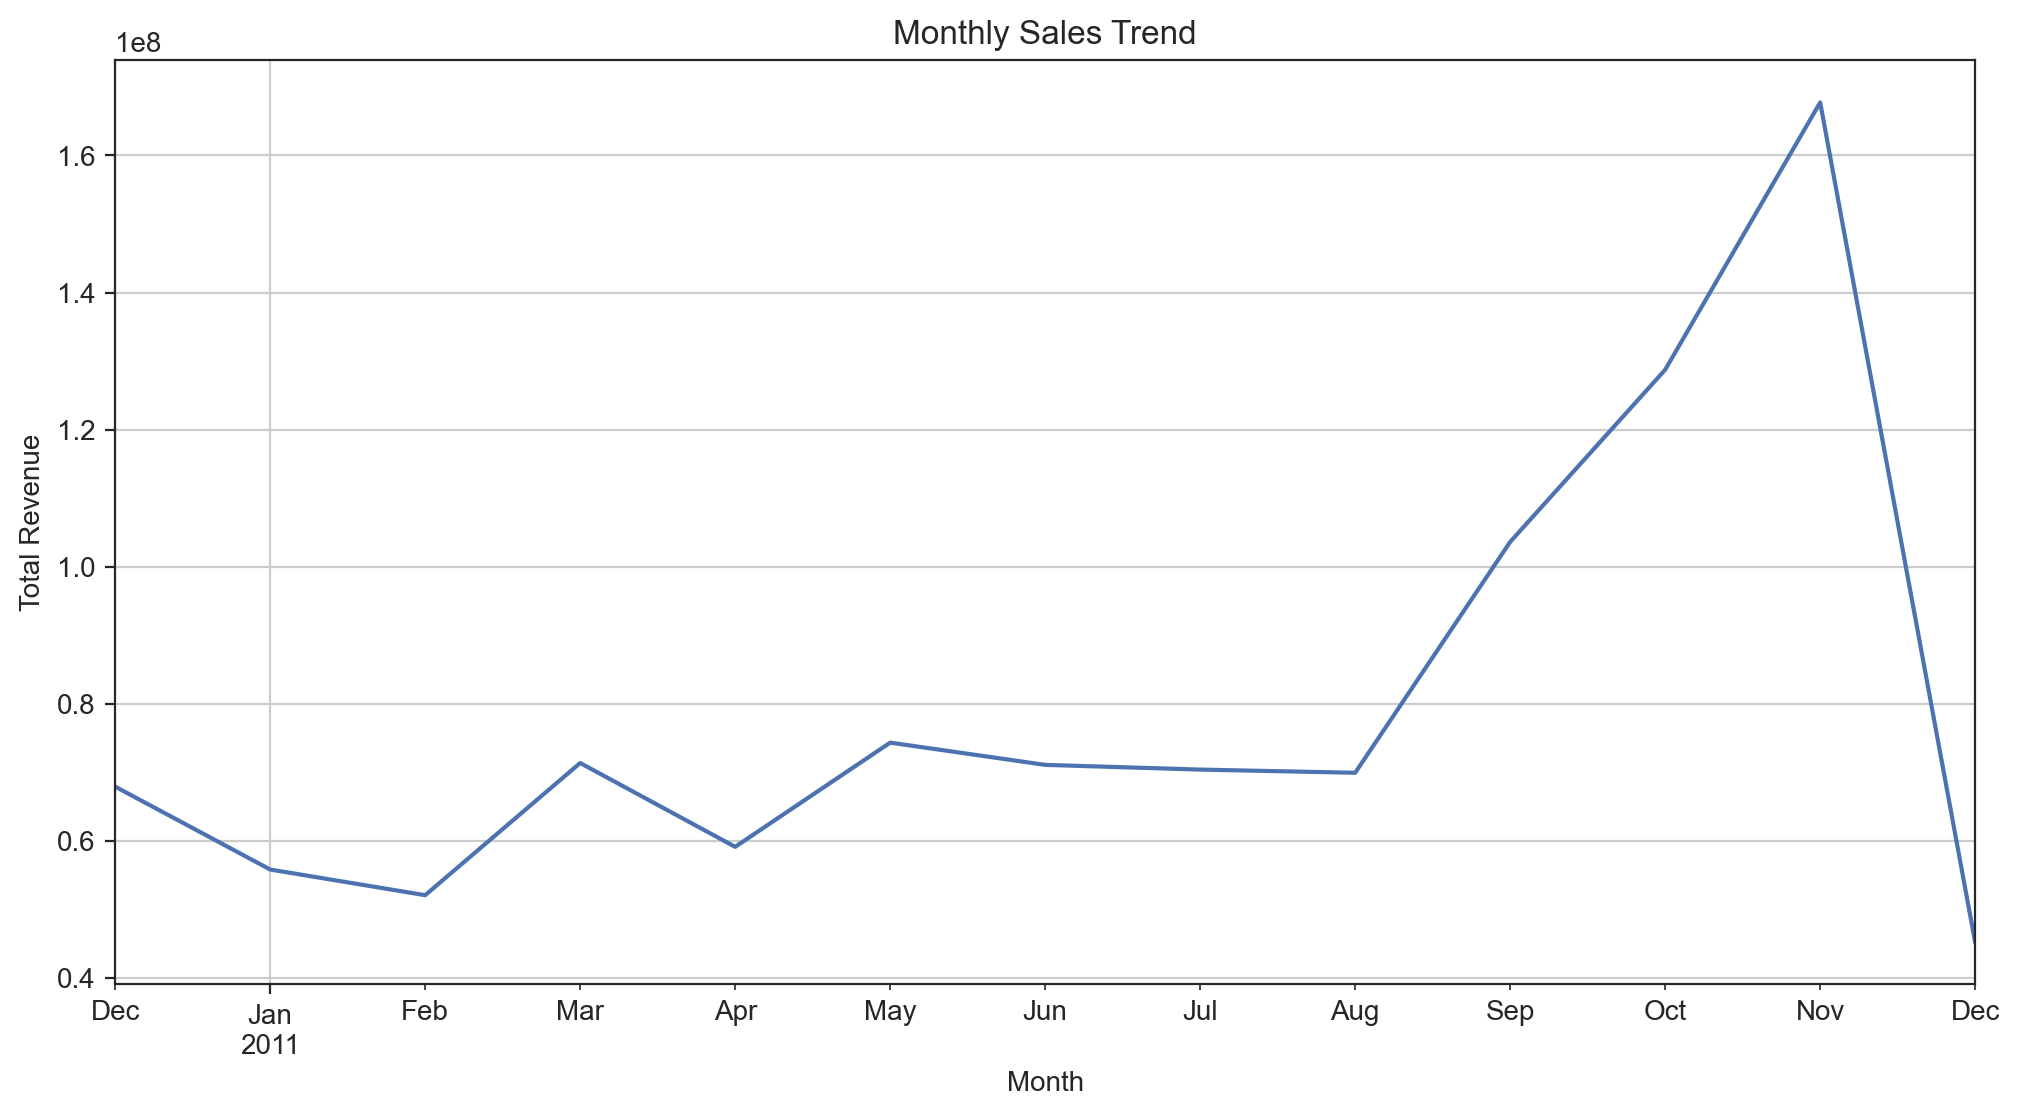

In [68]:
# Sales Trends Over Time
monthly_sales = ecom_data.groupby(ecom_data['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()

plt.figure(figsize=(12,6))
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

### Observation - initial dip: Sales slightly declined from December to February, reaching a low point in February.¶
### Moderate Recovery: There was a modest increase in March and May, but the trend remained relatively flat from June to August.
### Strong Growth Phase: Sales began to climb sharply from September to November, peaking in November — the highest revenue month.
### Sharp Drop: A dramatic drop occurred in December, likely due to seasonal closure e.g., holiday break or end of the data collection period.

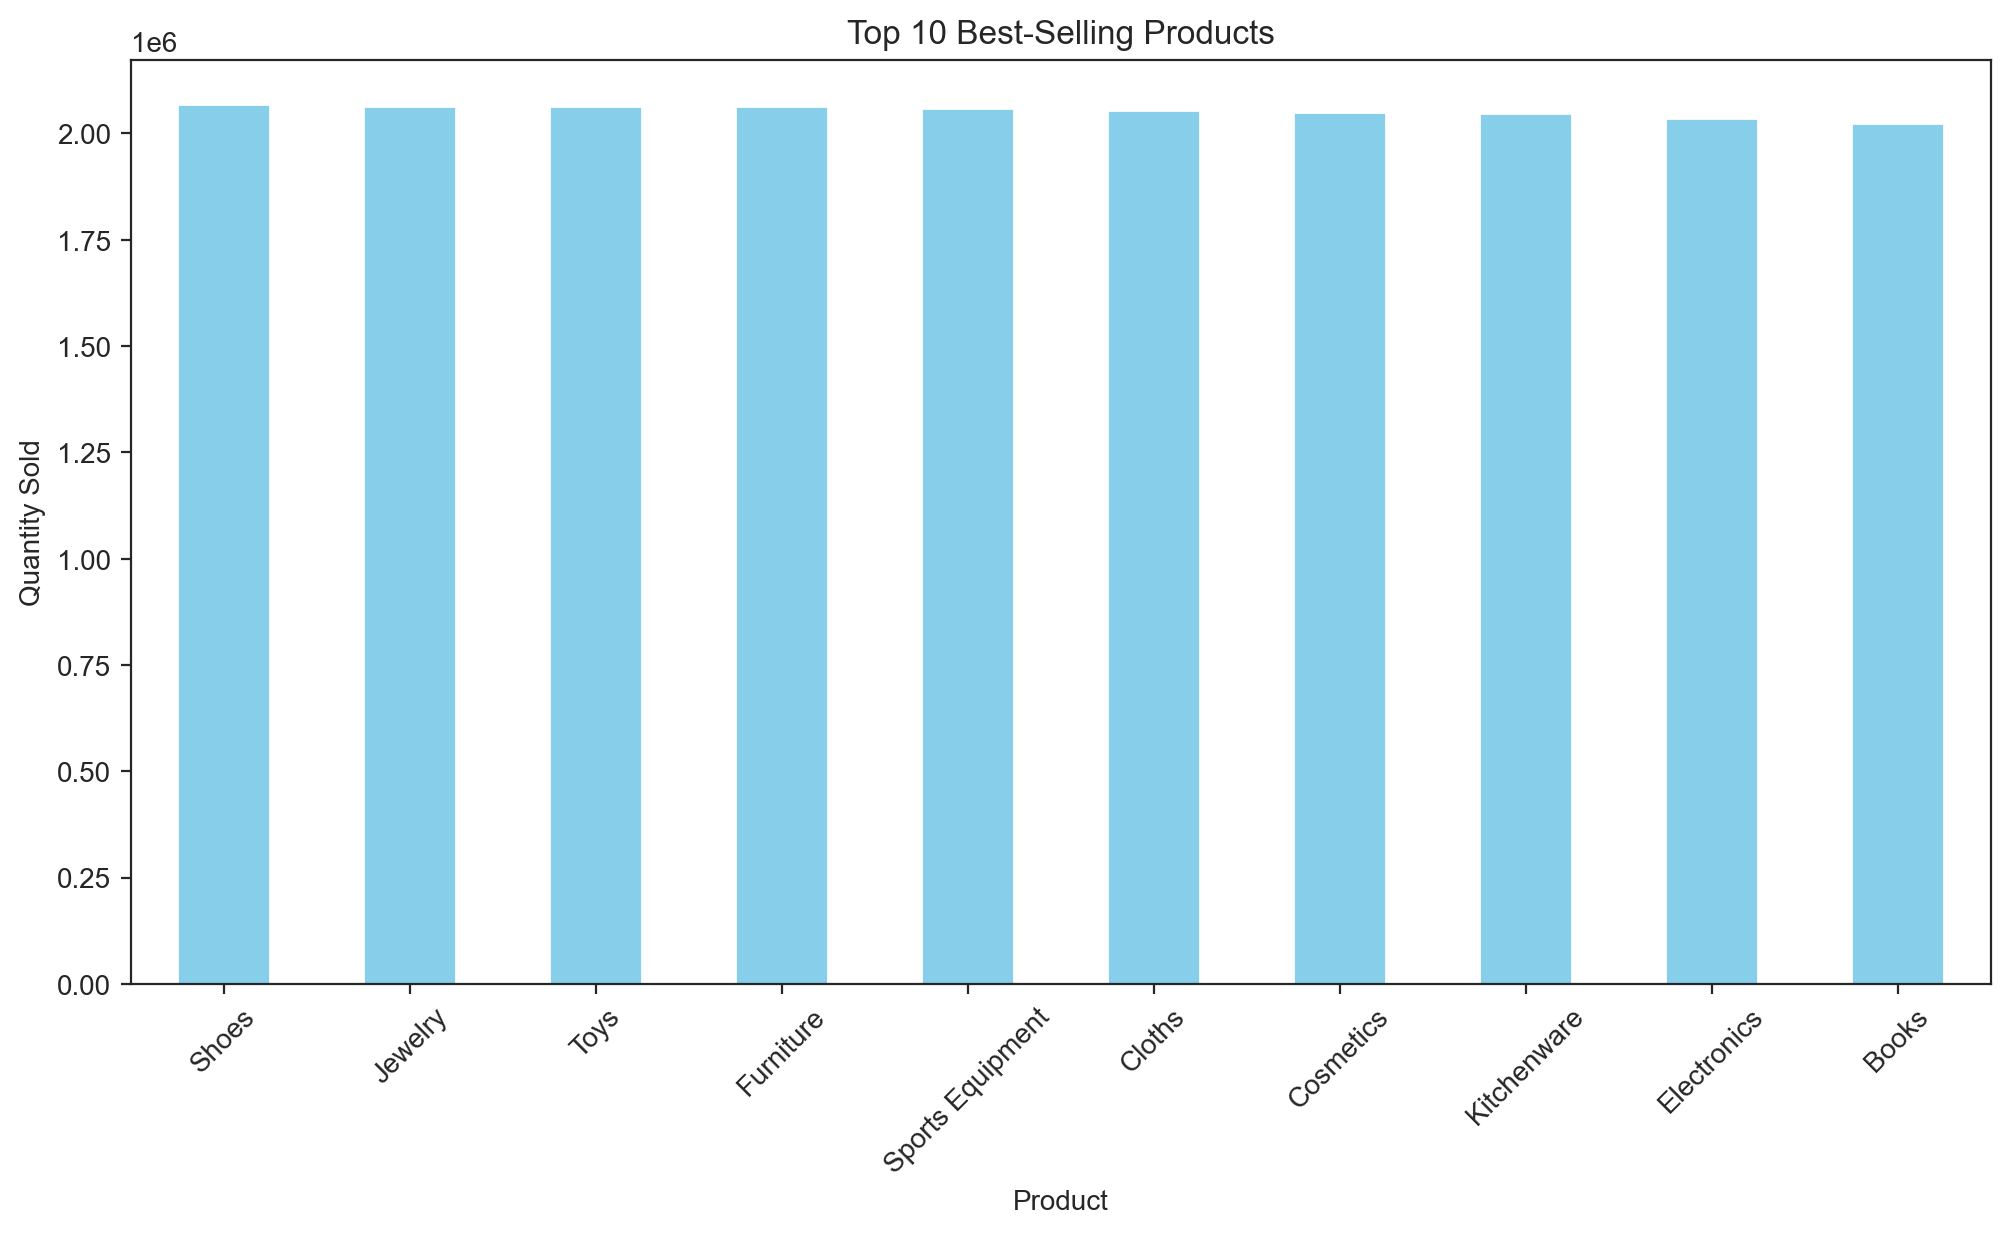

In [71]:
# Top Selling Products
# Total quantity sold per product
top_products = ecom_data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plot
top_products.plot(kind='bar', figsize=(12,6), color='skyblue')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Product')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.show()

### The bar chart above highlights the Top 10 Best-Selling Products based on the total quantity sold. The sales figures across these categories are nearly identical, with each product line approaching 2 million units sold. Shoes lead marginally, followed by Jewelry, Toys, and Furniture, among others.This uniformity suggests a well-diversified product portfolio with balanced consumer demand across different segments. Such even distribution of sales indicates effective inventory and marketing strategies, reducing over-dependence on any one product. Moreover, this can enhance business resilience and optimize overall performance throughout seasonal or market fluctuations.

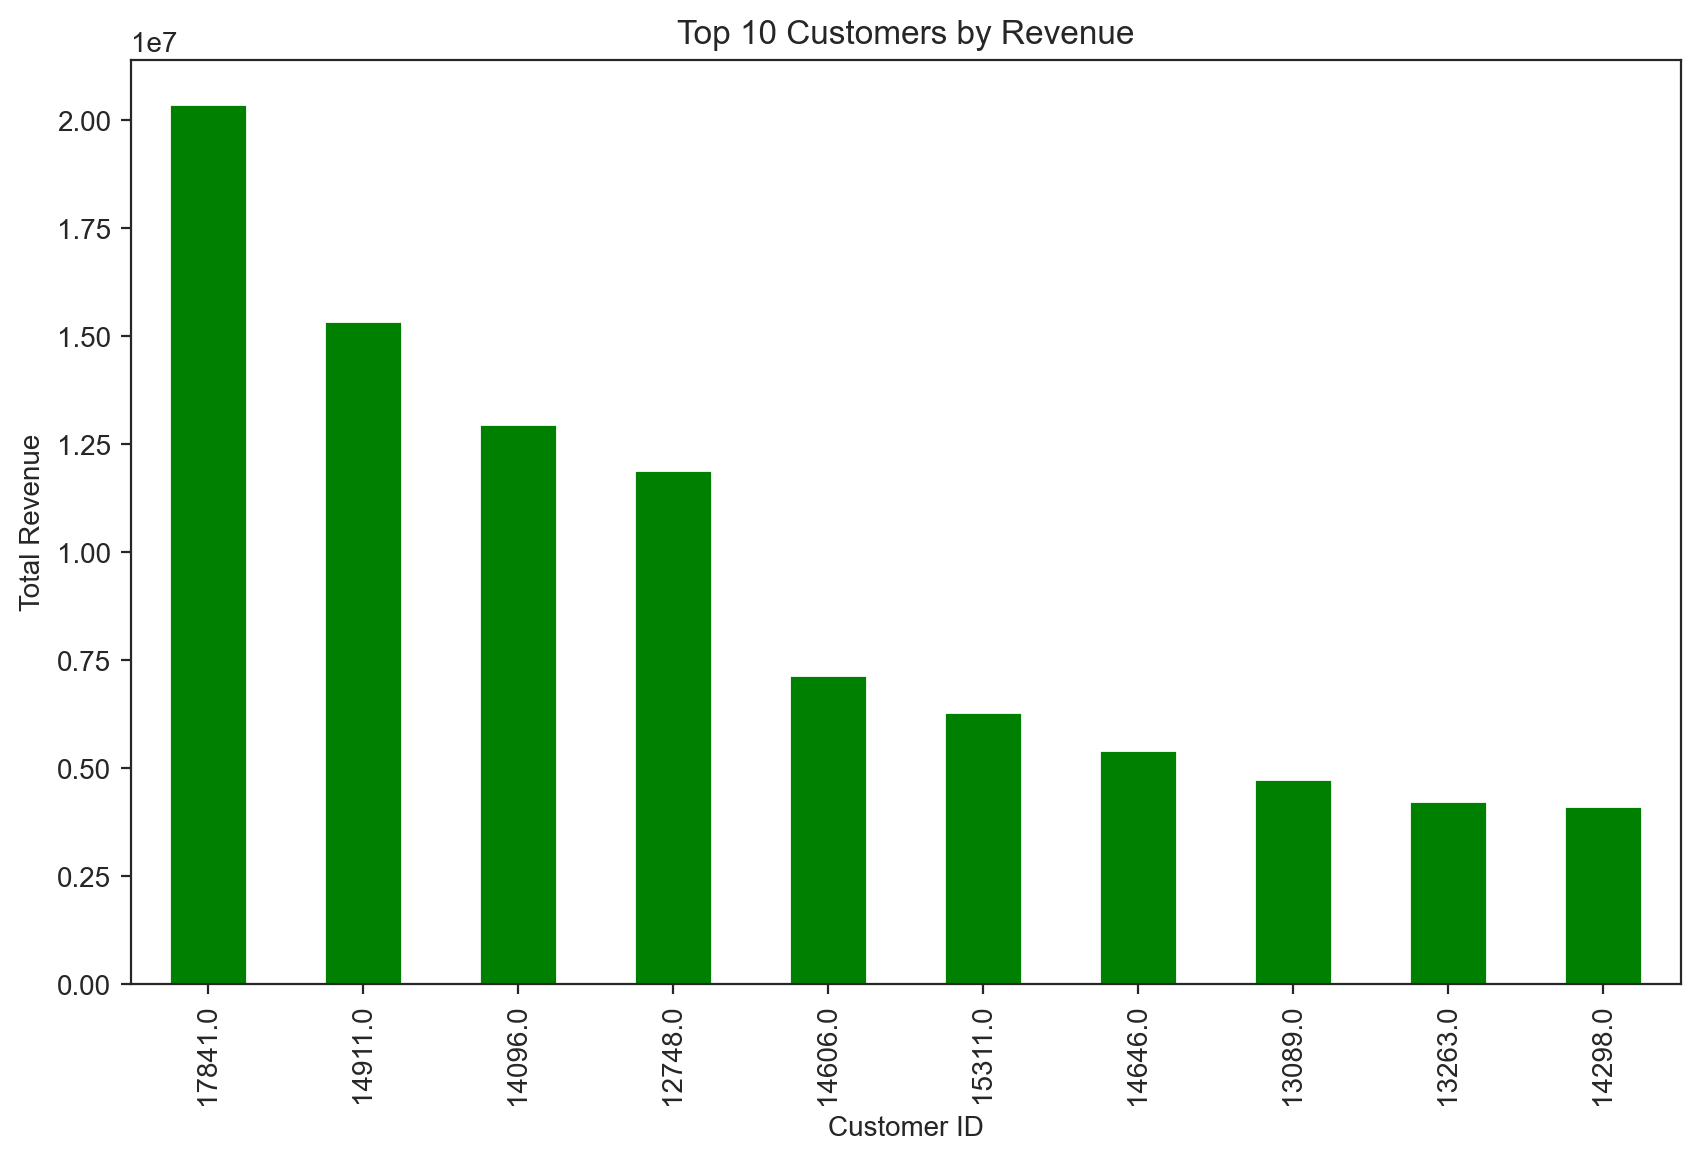

In [74]:
# Customer Purchase Behavior
# Total Revenue per Customer
customer_revenue = ecom_data.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)

customer_revenue.head(10).plot(kind='bar', figsize=(10,6), color='green')
plt.title('Top 10 Customers by Revenue')
plt.xlabel('Customer ID')
plt.ylabel('Total Revenue')
plt.show()

### The bar chart visualizes the Top 10 Customers by Total Revenue, highlighting the most valuable clients based on their purchasing behavior.
### - The customer with ID 17841.0 generated the highest revenue, exceeding 20 million in total. This customer stands out significantly compared to the rest, suggesting a very strong transactional relationship.
### - Following this, Customers 14911.0 and 14096.0 also contribute notably, each bringing in revenues between 13 and 15 million respectively.
### - There is a gradual decline in revenue as we move from left to right across the chart. The 10th highest customer (Customer ID 14298.0) still contributed over 5 million, but this is less than one-third of the top customer's contribution.
### - Overall, this pattern indicates a concentration of revenue among a few key clients, with a steep revenue drop beyond the top 5.
### Business Insight - The data suggests that a small number of customers account for a disproportionate share of total revenue, with the top 3 customers alone generating a significant chunk. This emphasizes the importance of customer relationship management and retention strategies for these high-value clients. At the same time, there is an opportunity to nurture mid-tier customers (like those ranked 6–10) to increase their spend and move them higher up the revenue ladder.

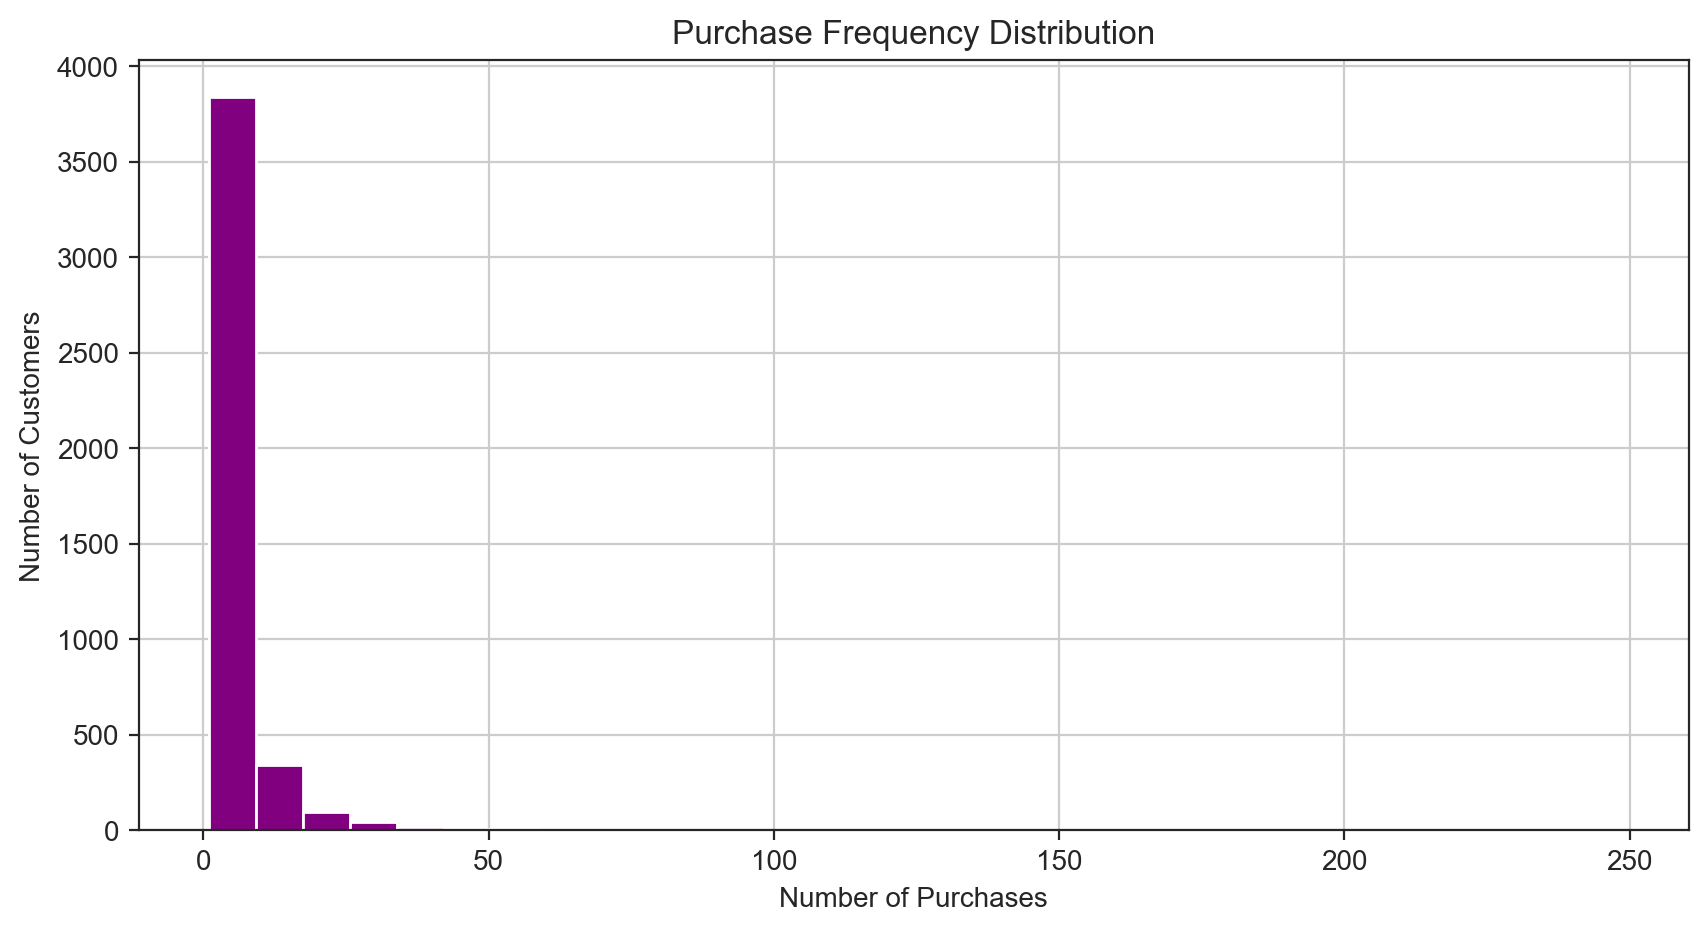

In [78]:
# Frequency of Purchase
customer_frequency = ecom_data.groupby('CustomerID')['InvoiceDate'].nunique()

customer_frequency.hist(bins=30, figsize=(10,5), color='purple')
plt.title('Purchase Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.show()

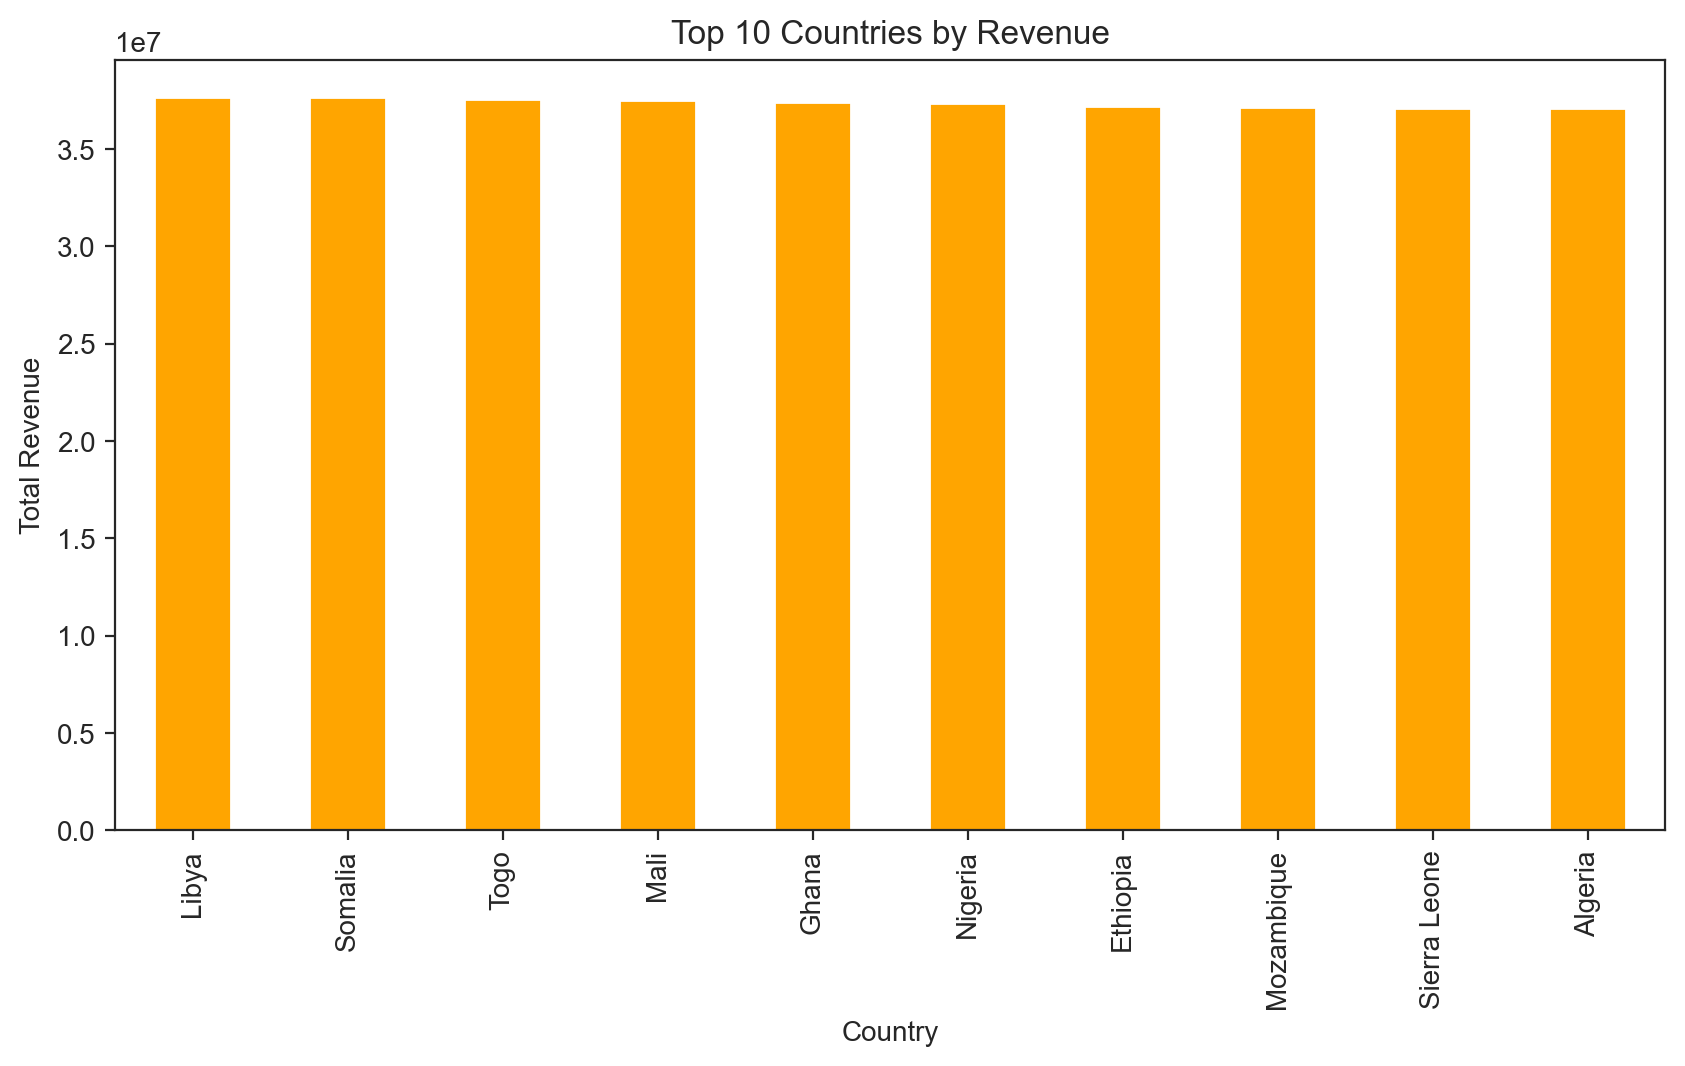

In [80]:
# Sales by Country
country_sales = ecom_data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

country_sales.plot(kind='bar', figsize=(10,5), color='orange')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.show()

### The bar chart visualizes the Top 10 Countries by Total Revenue, highlighting the countrue with the highest revenue based on their purchases. Libya at the top means customers from Libya made the most purchases or bought higher-priced items, followed by Somalia, then Togo, Mali, Ghana, down to Algeria. Countries at the top might be high-value markets for the business, this can inform targeted marketing strategies, e.g., offer premium services in Libya or Somalia. Interesting that many of the top countries are in Africa — this could reflect a niche or regional market the business serves.

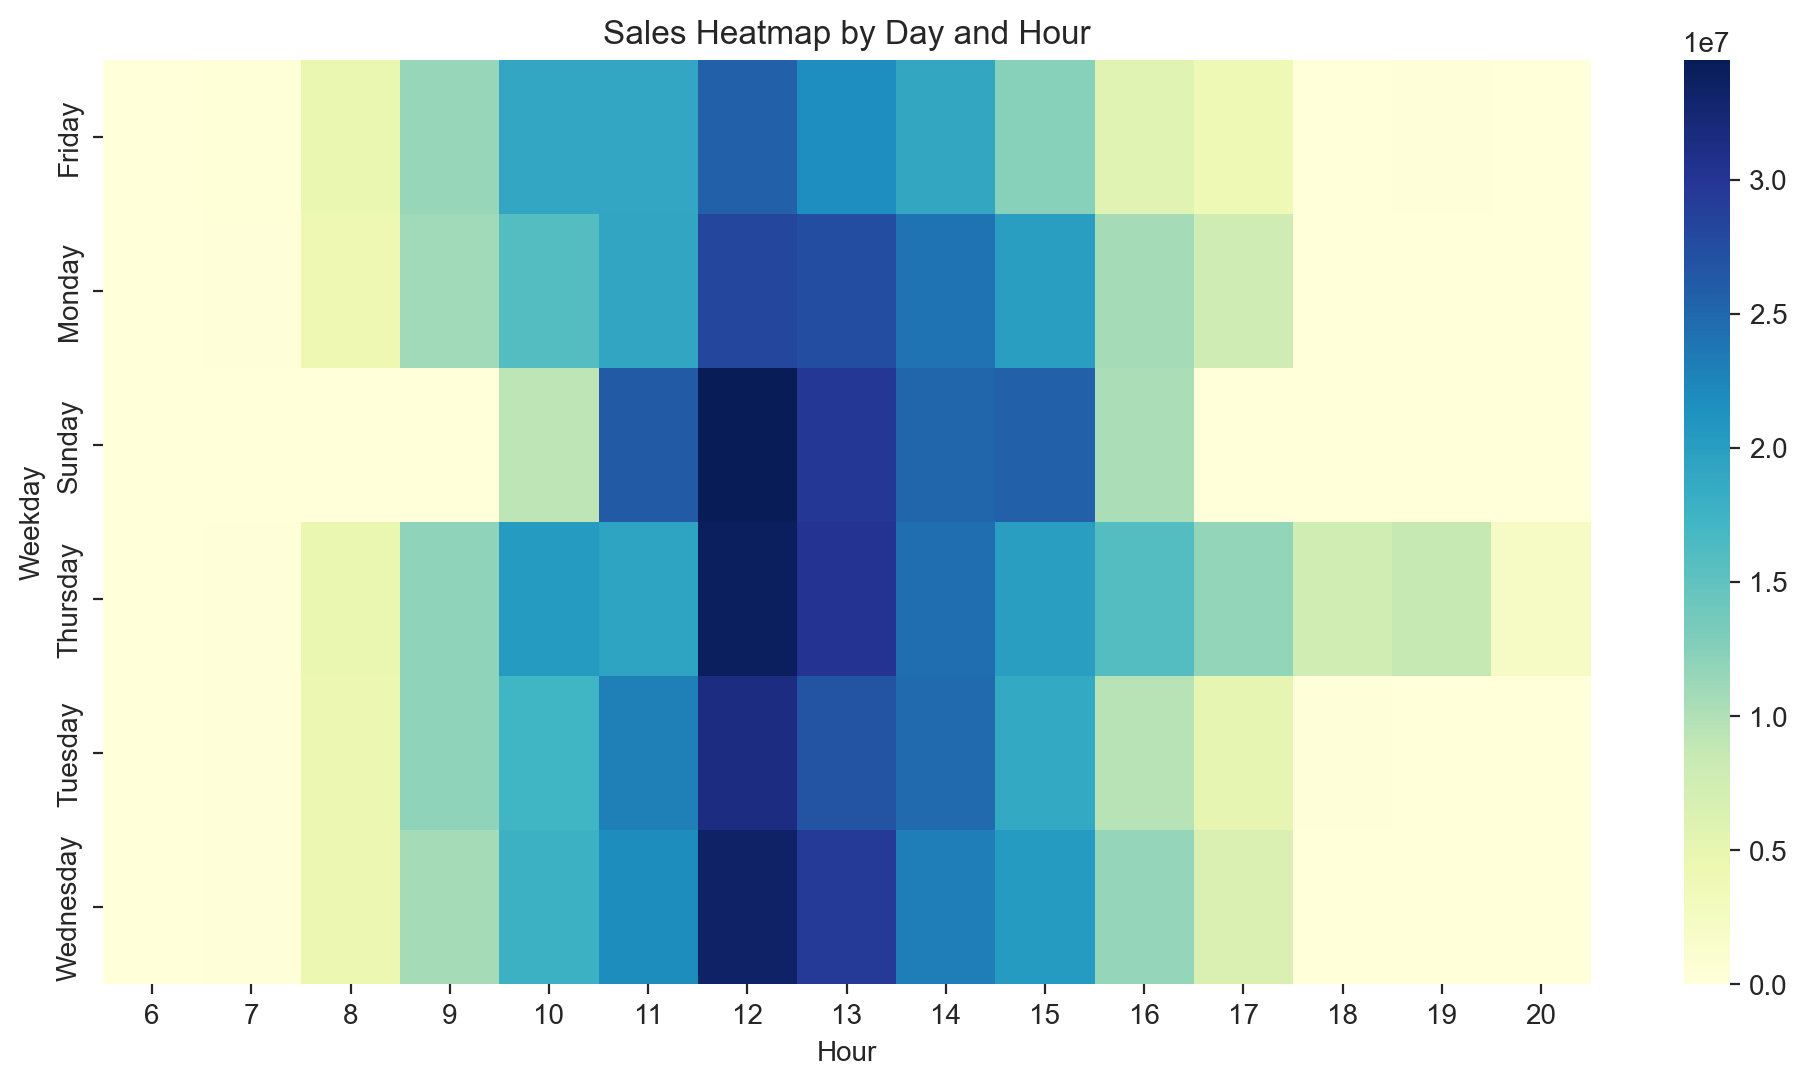

In [82]:
# Heatmap of Weekly Purchase Behavior
ecom_data['Weekday'] = ecom_data['InvoiceDate'].dt.day_name()
ecom_data['Hour'] = ecom_data['InvoiceDate'].dt.hour

heatmap_data = ecom_data.groupby(['Weekday', 'Hour'])['TotalPrice'].sum().unstack().fillna(0)

import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Sales Heatmap by Day and Hour')
plt.show()